In [1]:
import networkx as nx
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

from utils import *

## Flat clustering scores

In [2]:
def modularity(G, clusters, resolution=1.):
    clusters_dict = clusters_list2clusters_dict(clusters)
    n_nodes = G.number_of_nodes()
    wtot = 0.
    w = {u: 0. for u in range(n_nodes)}
    for (u, v) in G.edges():
        weight = G[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    W = 0.
    S = 0.
    for u in G.nodes():
        for v in G.nodes():
            if clusters_dict[u] == clusters_dict[v]:
                S += w[u] * w[v]
                if G.has_edge(u,v):
                    W += G[u][v]['weight']
    W /= float(wtot)
    S /= float(wtot)**2
    return W - resolution * S

In [3]:
def tsd_flat(graph, clusters):
    n_nodes = graph.number_of_nodes()
    cluster_dict = clusters_list2clusters_dict(clusters)
    
    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph.edges():
        weight = graph[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    p = {t: w[t]/float(wtot) for t in range(n_nodes)}
    
    W_k = {k: 0 for k in range(len(clusters))}
    for u in graph.nodes():
        W_k[cluster_dict[u]] += w[u]
        
    w_k = {k: 0 for k in range(len(clusters))}
    for (u, v) in graph.edges():
        if cluster_dict[u] == cluster_dict[v]:
            w_k[cluster_dict[u]] += graph[u][v]['weight']
    
    sum_log = 0
    sum_w = 0
    sum_W2 = 0
    for k in range(len(clusters)):
        sum_log += w_k[k] / float(wtot) * np.log(wtot * w_k[k] / float(W_k[k]**2))
        sum_w += w_k[k] / float(wtot)
        sum_W2 += (W_k[k] / float(wtot))**2
    
    tsd_flat = sum_log + (1 - sum_w) * np.log((1 - sum_w) / (1 - sum_W2))
    
    norm = 0
    for u, v in graph.edges():
        p_uv = 2 * graph[u][v]['weight'] / float(wtot)
        norm += p_uv * np.log(p_uv / (p[u] * p[v]))
    tsd_flat /= norm
    
    return tsd_flat

# Experiments: modularity correlation

In [4]:
flat_algorithms = {'louvain_1': lambda graph: louvain(graph, resolution=1.),
                   'louvain_2': lambda graph: louvain(graph, resolution=2.),
                   'louvain_3': lambda graph: louvain(graph, resolution=5.),
                   'louvain_3': lambda graph: louvain(graph, resolution=10.),
                   'spectral_2': lambda graph: spectral_clustering(graph, n_clusters=2),
                   'spectral_3': lambda graph: spectral_clustering(graph, n_clusters=3),
                   'spectral_4': lambda graph: spectral_clustering(graph, n_clusters=4),
                   'spectral_5': lambda graph: spectral_clustering(graph, n_clusters=5),
                   'spectral_6': lambda graph: spectral_clustering(graph, n_clusters=10),
                   'spectral_7': lambda graph: spectral_clustering(graph, n_clusters=20)}

In [4]:
def shuffle(graph, p):
    graph_copy = graph.copy()
    for u, v in list(graph_copy.edges()):
        if np.random.choice([True, False], p=[p, 1 - p]):
            u_, v_ = np.random.choice(graph_copy.nodes(), 2, replace=False)
            graph_copy.add_edge(u_, v_, weight=graph_copy[u][v]['weight'])
            graph_copy.remove_edge(u, v)
    return graph_copy

In [5]:
def shuffle_clusters(clusters, p):
    shuffled_clusters = [[] for i in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        for u in cluster:
            if np.random.choice([True, False], p=[p, 1 - p]):
                j = np.random.choice(len(clusters))
                while j == i:
                    j = np.random.choice(len(clusters))
                shuffled_clusters[j].append(u)
            else:
                shuffled_clusters[i].append(u)
    
    return shuffled_clusters

In [7]:
clean_ppm = PPM([20, 20, 20, 20, 20], .5, .01)
#clean_ppm = PPM([60, 60, 15, 15, 15, 15], .2, .01)
graph = clean_ppm.create_graph(distribution='Binomial')
n_nodes = graph.number_of_nodes()
mod, tsd_f = [], []
for p in np.linspace(0., 1., num=100):
    shuffled_graph = shuffle(graph, p)
    for algo_name, algo in flat_algorithms.items():
        clusters = algo(shuffled_graph)
        
        mod.append(modularity(graph, clusters))
        tsd_f.append(tsd_flat(graph, clusters))

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


/opt/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


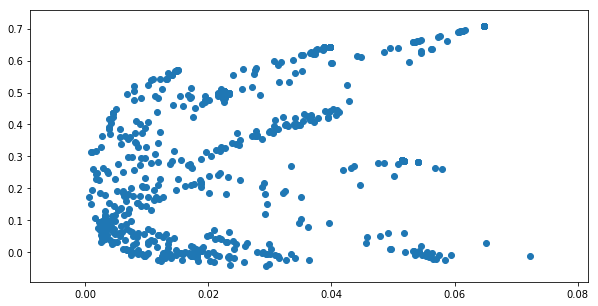

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(tsd_f, mod)
plt.legend()
plt.show()

## Experiment: clustering correlation

In [89]:
clean_ppm = PPM([100, 10, 10, 10, 10], .5, .01)
graph = clean_ppm.create_graph(distribution='Binomial')
n_nodes = graph.number_of_nodes()
n_samples = 10
n_p = 10
mod, tsd_f = np.zeros((n_p, n_samples)), np.zeros((n_p, n_samples))
for k_p, p in enumerate(np.linspace(0., 1., num=n_p)):
    for k_sample in range(n_samples):
        shuffled_graph = shuffle(graph, p)
        clusters = spectral_clustering(shuffled_graph, n_clusters=5)

        mod[k_p][k_sample] = modularity(graph, clusters)
        tsd_f[k_p][k_sample] = tsd_flat(graph, clusters)

In [90]:
np.savetxt("mod-noise-1.txt", mod)
np.savetxt("tsd_f-noise-1.txt", tsd_f)

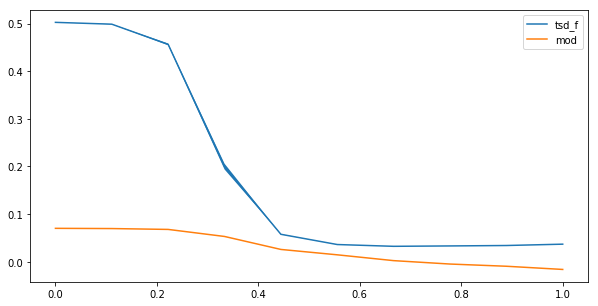

In [91]:
plt.figure(figsize=(10,5))
x = np.linspace(0., 1., num=n_p)
plt.plot(x, np.mean(tsd_f, axis=1), label='tsd_f')
plt.fill_between(x, np.mean(tsd_f, axis=1) - np.var(tsd_f, axis=1), np.mean(tsd_f, axis=1) + np.var(tsd_f, axis=1))
plt.plot(x, np.mean(mod, axis=1), label='mod')
plt.fill_between(x, np.mean(mod, axis=1) - np.var(mod, axis=1), np.mean(mod, axis=1) + np.var(mod, axis=1))
plt.legend()
plt.show()

In [92]:
clean_ppm = PPM([20, 20, 20, 20, 20, 20, 20, 20, 20], .9, .001)
graph = clean_ppm.create_graph(distribution='Binomial')
n_nodes = graph.number_of_nodes()
n_samples = 10
n_p = 10
mod, tsd_f = np.zeros((n_p, n_samples)), np.zeros((n_p, n_samples))
for k_p, p in enumerate(np.linspace(0., 1., num=n_p)):
    for k_sample in range(n_samples):
        shuffled_graph = shuffle(graph, p)
        clusters = spectral_clustering(shuffled_graph, n_clusters=5)

        mod[k_p][k_sample] = modularity(graph, clusters)
        tsd_f[k_p][k_sample] = tsd_flat(graph, clusters)

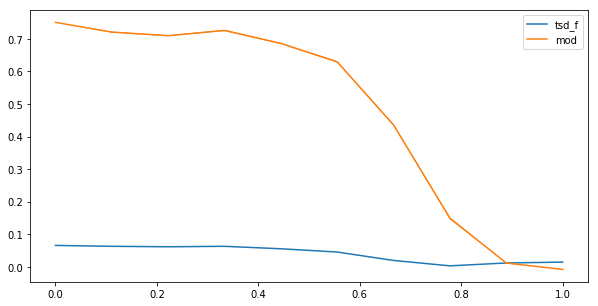

In [93]:
plt.figure(figsize=(10,5))
x = np.linspace(0., 1., num=n_p)
plt.plot(x, np.mean(tsd_f, axis=1), label='tsd_f')
plt.fill_between(x, np.mean(tsd_f, axis=1) - np.var(tsd_f, axis=1), np.mean(tsd_f, axis=1) + np.var(tsd_f, axis=1))
plt.plot(x, np.mean(mod, axis=1), label='mod')
plt.fill_between(x, np.mean(mod, axis=1) - np.var(mod, axis=1), np.mean(mod, axis=1) + np.var(mod, axis=1))
plt.legend()
plt.show()

In [94]:
n_p = 50
n_samples = 10
mod, tsd_f = np.zeros((n_p, n_samples)), np.zeros((n_p, n_samples))
for k_p, p in enumerate(np.linspace(0.01, .5, num=n_p)):
    #clean_ppm = PPM([20, 20, 20, 20, 20, 20, 20, 20, 20], .5, p)
    clean_ppm = PPM([100, 10, 10, 10, 10], .5, p)
    clusters = clean_ppm._clusters
    
    for k_sample in range(n_samples):
        graph = clean_ppm.create_graph(distribution='Binomial')

        mod[k_p][k_sample] = modularity(graph, clusters)
        tsd_f[k_p][k_sample] = tsd_flat(graph, clusters)

In [95]:
np.savetxt("mod-noise-2.txt", mod)
np.savetxt("tsd_f-noise-2.txt", tsd_f)

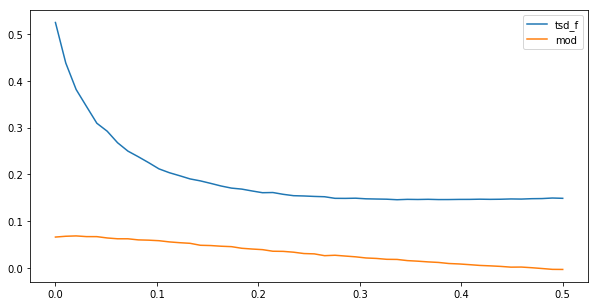

In [96]:
plt.figure(figsize=(10, 5))
x = np.linspace(0., .5, num=n_p)
plt.plot(x, np.mean(tsd_f, axis=1), label='tsd_f')
plt.fill_between(x, np.mean(tsd_f, axis=1) - np.var(tsd_f, axis=1), np.mean(tsd_f, axis=1) + np.var(tsd_f, axis=1), alpha=.5)
plt.plot(x, np.mean(mod, axis=1), label='mod')
plt.fill_between(x, np.mean(mod, axis=1) - np.var(mod, axis=1), np.mean(mod, axis=1) + np.var(mod, axis=1), alpha=.5)
plt.legend()
plt.show()

## Experiment: modularity vs tsd_flat with heterogeneous clusterings

In [82]:
range_param = range(1, 11)
samples, true_clusters, random_clusters = block_size_ratio_samples(range_ratio=range_param, big_block_size=100, graph_size=600, p_in=.9, p_out=.01, n_samples=10)

In [83]:
for i in range(len(random_clusters)):
    for j in range(len(random_clusters[i])):
        random_clusters[i][j] = shuffle_clusters(true_clusters[i][j], p=.5)

In [84]:
mod_res_t = samples_evaluation(samples, true_clusters, modularity)
mod_res_r = samples_evaluation(samples, random_clusters, modularity)
tsd_res_t = samples_evaluation(samples, true_clusters, tsd_flat)
tsd_res_r = samples_evaluation(samples, random_clusters, tsd_flat)

In [85]:
def plot_results(results, range_param, label='', color='r', marker='o'):
    mean_results = np.mean(results, axis=1)
    min_results = np.mean(results, axis=1) - np.std(results, axis=1)
    max_results = np.mean(results, axis=1) + np.std(results, axis=1)
    plt.plot(range_param, mean_results, marker=marker, color=color, label=label)
    plt.fill_between(range_param, min_results, max_results, facecolor=color, interpolate=True, alpha=.2)

In [86]:
mod_res_t = np.array(mod_res_t)
mod_res_r = np.array(mod_res_r)
tsd_res_t = np.array(tsd_res_t)
tsd_res_r = np.array(tsd_res_r)

In [87]:
np.savetxt("mod_res_t.txt", mod_res_t)
np.savetxt("mod_res_r.txt", mod_res_r)
np.savetxt("tsd_res_t.txt", tsd_res_t)
np.savetxt("tsd_res_r.txt", tsd_res_r)

mod_res_t = np.loadtxt("mod_res_t.txt")
mod_res_r = np.loadtxt("mod_res_r.txt")
tsd_res_t = np.loadtxt("tsd_res_t.txt")
tsd_res_r = np.loadtxt("tsd_res_r.txt")

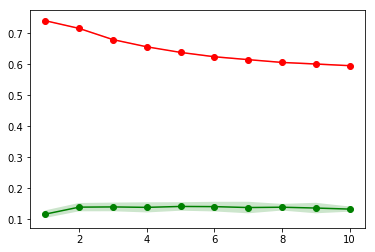

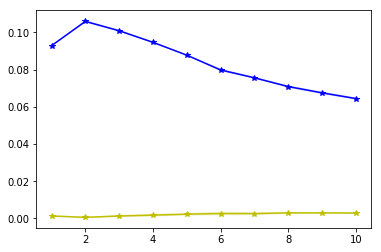

In [88]:
plot_results(mod_res_t, range_param, label='', color='r', marker='o')
plot_results(mod_res_r, range_param, label='', color='g', marker='o')
plt.show()

plot_results(tsd_res_t, range_param, label='', color='b', marker='*')
plot_results(tsd_res_r, range_param, label='', color='y', marker='*')
plt.show()